This notebook contains several instructions and example of using GPU-accelerated libraries in Python to speedup your program. 

There are 3 main libraries that I will go through in this notebook:

* Numba: Compiling Python code to CUDA
* RAPIDS: Including cuDF and cuML for dataframe process and machine learning
* Dask: scalable GPU-accelerated library

# Check device

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

### We can see that by choosing free GPU accelerator from Colab, we have a Tesla T4.

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11793359897457365902
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14415560704
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 3583562575357163995
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

### the output implies that a GPU is connected. 
### If we turn off the GPU connection in Colab, this will return None

'/device:GPU:0'

# Dask demo

## Dataframe with Dask

In [ ]:
### installation
!pip install dask

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import files
from google.colab import drive
import os
drive.mount('/content/gdrive', force_remount = True)

Mounted at /content/gdrive


Let's start with importing dataframe, we will try with pandas and dask.dataframe

In [ ]:
## pandas first
import pandas as pd
def func():
  test = pd.read_csv(r'/content/gdrive/My Drive/Colab Notebooks/multi_data/Testing_data(1).csv')
  return test

%time func()

CPU times: user 17.1 s, sys: 1.79 s, total: 18.9 s
Wall time: 22.9 s


,brand,keywords,Category Level 1,Category Level 2,Category Level 3,Product ID,image,url,price,sale-price,shop name,title
0,NoBrand,NoBrand,Stationery,Letters & Envelopes,Envelopes & Angpao,14730379660,http://cf.shopee.vn/file/35f9f01577866022be8e5...,https://shopee.vn/Set-60-d%E1%BB%A5ng-c%E1%BB%...,125000,104000,menhuan.vn,Set 60 dụng cụ theo dõi đường ray màu đen cho ...
1,NoBrand,NoBrand,Women Shoes,Flats,Loafers & Boat Shoes,11965049267,http://cf.shopee.vn/file/1c23711743d4654c5b15b...,https://shopee.vn/gi%C3%A0y-b%E1%BB%87t-chu%E1...,204000,204000,bimbim68,giày bệt chuẩn hãng UK
2,NoBrand,NoBrand,Home & Living,Home Care Supplies,Laundry Care,17842087461,http://cf.shopee.vn/file/d2b979a3f23ac60d6c920...,https://shopee.vn/Electric-Lint-Remover-6-Leaf...,484000,313000,ababixa.vn,Electric Lint Remover 6-Leaf Blades USB Chargi...
3,Fujifilm,Fujifilm,Cameras & Drones,Lenses,NaN,4829798239,http://cf.shopee.vn/file/b30087abb0a7060b98472...,https://shopee.vn/-M%C3%A3-255ELSALE-gi%E1%BA%...,20900000,20900000,VJSHOP,[Mã 255ELSALE giảm 7% đơn 300K] Ống kính Fujif...
4,NoBrand,NoBrand,Women Clothes,Dresses,NaN,3887608320,http://cf.shopee.vn/file/687b95483cdbfa1e46eff...,https://shopee.vn/V%C3%A1y-maxi-t%C6%A1-hoa-c%...,485000,350000,Socomostore - Socomo,"Váy maxi tơ hoa cổ yếm xẻ đùi - Hàng loại 1, c..."
...,...,...,...,...,...,...,...,...,...,...,...,...
2167004,NaN,NaN,Baby & Kids Fashion,Baby & Kids Accessories,Hair Accessories,7314727000,http://cf.shopee.vn/file/8ea3e8e224aee93932ec9...,https://shopee.vn/B%C4%83ng-%C4%91%C3%B4-n%C6%...,8600,4300,PrettyBaby.vn,Băng đô nơ đơn giản và dễ thương cho bé gái
2167005,NaN,NaN,Women Clothes,Tops,Shirts & Blouses,4653479098,http://cf.shopee.vn/file/a737589913edb7199fa92...,https://shopee.vn/%C3%A1o-s%C6%A1mi-kaki-ph%E1...,240000,240000,thor.store,áo sơmi kaki phối nón
2167006,NoBrand,NoBrand,Food & Beverages,Snacks,Others,14819212458,http://cf.shopee.vn/file/ea3c3dc074ce058eb8de4...,https://shopee.vn/B%C3%81NH-L%E1%BB%96-TAI-HEO...,18000,18000,BƯỚM' HOUSE - Food & Drink,BÁNH LỖ TAI HEO - BÁNH TRUYỀN THỐNG - ĂN VẶT T...
2167007,gor,gor,Mobile & Gadgets,Accessories,Screen Protectors,2812418185,http://cf.shopee.vn/file/b953cd4821602bbf6eaee...,https://shopee.vn/B%E1%BB%99-2-c%C6%B0%E1%BB%9...,56000,56000,Phụ Kiện HM Case,Bộ 2 cường Lực Gor Redmi Note 8 / Note 8 Pro K...


In [ ]:
import dask.dataframe as dd
def func_dd():
  test = dd.read_csv(r'/content/gdrive/My Drive/Colab Notebooks/multi_data/Testing_data(1).csv')
  return test

%time func_dd()

CPU times: user 7.98 ms, sys: 80.8 ms, total: 88.8 ms
Wall time: 99.1 ms


,brand,keywords,Category Level 1,Category Level 2,Category Level 3,Product ID,image,url,price,sale-price,shop name,title
npartitions=16,,,,,,,,,,,,
,object,object,object,object,object,int64,object,object,int64,int64,object,object
,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...


We can see that, with a dataset of 2m+ rows and 12 cols it takes pandas nearly 20 second to import, meanwhile dask only takes 23 ms. An impressive performance!

In [ ]:
### let's try some basic Pandas function
df = func_dd()
df.head()

,brand,keywords,Category Level 1,Category Level 2,Category Level 3,Product ID,image,url,price,sale-price,shop name,title
0,NoBrand,NoBrand,Stationery,Letters & Envelopes,Envelopes & Angpao,14730379660,http://cf.shopee.vn/file/35f9f01577866022be8e5...,https://shopee.vn/Set-60-d%E1%BB%A5ng-c%E1%BB%...,125000,104000,menhuan.vn,Set 60 dụng cụ theo dõi đường ray màu đen cho ...
1,NoBrand,NoBrand,Women Shoes,Flats,Loafers & Boat Shoes,11965049267,http://cf.shopee.vn/file/1c23711743d4654c5b15b...,https://shopee.vn/gi%C3%A0y-b%E1%BB%87t-chu%E1...,204000,204000,bimbim68,giày bệt chuẩn hãng UK
2,NoBrand,NoBrand,Home & Living,Home Care Supplies,Laundry Care,17842087461,http://cf.shopee.vn/file/d2b979a3f23ac60d6c920...,https://shopee.vn/Electric-Lint-Remover-6-Leaf...,484000,313000,ababixa.vn,Electric Lint Remover 6-Leaf Blades USB Chargi...
3,Fujifilm,Fujifilm,Cameras & Drones,Lenses,NaN,4829798239,http://cf.shopee.vn/file/b30087abb0a7060b98472...,https://shopee.vn/-M%C3%A3-255ELSALE-gi%E1%BA%...,20900000,20900000,VJSHOP,[Mã 255ELSALE giảm 7% đơn 300K] Ống kính Fujif...
4,NoBrand,NoBrand,Women Clothes,Dresses,NaN,3887608320,http://cf.shopee.vn/file/687b95483cdbfa1e46eff...,https://shopee.vn/V%C3%A1y-maxi-t%C6%A1-hoa-c%...,485000,350000,Socomostore - Socomo,"Váy maxi tơ hoa cổ yếm xẻ đùi - Hàng loại 1, c..."


In [ ]:
df.info

<bound method DataFrame.info of Dask DataFrame Structure:
                 brand keywords Category Level 1 Category Level 2 Category Level 3 Product ID   image     url  price sale-price shop name   title
npartitions=16                                                                                                                                   
                object   object           object           object           object      int64  object  object  int64      int64    object  object
                   ...      ...              ...              ...              ...        ...     ...     ...    ...        ...       ...     ...
...                ...      ...              ...              ...              ...        ...     ...     ...    ...        ...       ...     ...
                   ...      ...              ...              ...              ...        ...     ...     ...    ...        ...       ...     ...
                   ...      ...              ...              ... 

In [ ]:
df.dtypes

brand               object
keywords            object
Category Level 1    object
Category Level 2    object
Category Level 3    object
Product ID           int64
image               object
url                 object
price                int64
sale-price           int64
shop name           object
title               object
dtype: object

In [ ]:
### concatenation
df_ = dd.concat([df, df], axis = 0)

In [ ]:
### mapping
df['new feature'] = df['keywords'].map(lambda x: "Branded" if x != "NoBrand" else "NoBrand")
df.head()

,brand,keywords,Category Level 1,Category Level 2,Category Level 3,Product ID,image,url,price,sale-price,shop name,title,new feature
0,NoBrand,NoBrand,Stationery,Letters & Envelopes,Envelopes & Angpao,14730379660,http://cf.shopee.vn/file/35f9f01577866022be8e5...,https://shopee.vn/Set-60-d%E1%BB%A5ng-c%E1%BB%...,125000,104000,menhuan.vn,Set 60 dụng cụ theo dõi đường ray màu đen cho ...,NoBrand
1,NoBrand,NoBrand,Women Shoes,Flats,Loafers & Boat Shoes,11965049267,http://cf.shopee.vn/file/1c23711743d4654c5b15b...,https://shopee.vn/gi%C3%A0y-b%E1%BB%87t-chu%E1...,204000,204000,bimbim68,giày bệt chuẩn hãng UK,NoBrand
2,NoBrand,NoBrand,Home & Living,Home Care Supplies,Laundry Care,17842087461,http://cf.shopee.vn/file/d2b979a3f23ac60d6c920...,https://shopee.vn/Electric-Lint-Remover-6-Leaf...,484000,313000,ababixa.vn,Electric Lint Remover 6-Leaf Blades USB Chargi...,NoBrand
3,Fujifilm,Fujifilm,Cameras & Drones,Lenses,NaN,4829798239,http://cf.shopee.vn/file/b30087abb0a7060b98472...,https://shopee.vn/-M%C3%A3-255ELSALE-gi%E1%BA%...,20900000,20900000,VJSHOP,[Mã 255ELSALE giảm 7% đơn 300K] Ống kính Fujif...,Branded
4,NoBrand,NoBrand,Women Clothes,Dresses,NaN,3887608320,http://cf.shopee.vn/file/687b95483cdbfa1e46eff...,https://shopee.vn/V%C3%A1y-maxi-t%C6%A1-hoa-c%...,485000,350000,Socomostore - Socomo,"Váy maxi tơ hoa cổ yếm xẻ đùi - Hàng loại 1, c...",NoBrand


In [ ]:
columns_to_drop = ['new feature']
df = df.drop(columns_to_drop, axis=1) # Drop the columns
pd_df = df.compute()  #  Create a Pandas dataframe

In [ ]:
pd_df

,brand,keywords,Category Level 1,Category Level 2,Category Level 3,Product ID,image,url,price,sale-price,shop name,title
0,NoBrand,NoBrand,Stationery,Letters & Envelopes,Envelopes & Angpao,14730379660,http://cf.shopee.vn/file/35f9f01577866022be8e5...,https://shopee.vn/Set-60-d%E1%BB%A5ng-c%E1%BB%...,125000,104000,menhuan.vn,Set 60 dụng cụ theo dõi đường ray màu đen cho ...
1,NoBrand,NoBrand,Women Shoes,Flats,Loafers & Boat Shoes,11965049267,http://cf.shopee.vn/file/1c23711743d4654c5b15b...,https://shopee.vn/gi%C3%A0y-b%E1%BB%87t-chu%E1...,204000,204000,bimbim68,giày bệt chuẩn hãng UK
2,NoBrand,NoBrand,Home & Living,Home Care Supplies,Laundry Care,17842087461,http://cf.shopee.vn/file/d2b979a3f23ac60d6c920...,https://shopee.vn/Electric-Lint-Remover-6-Leaf...,484000,313000,ababixa.vn,Electric Lint Remover 6-Leaf Blades USB Chargi...
3,Fujifilm,Fujifilm,Cameras & Drones,Lenses,NaN,4829798239,http://cf.shopee.vn/file/b30087abb0a7060b98472...,https://shopee.vn/-M%C3%A3-255ELSALE-gi%E1%BA%...,20900000,20900000,VJSHOP,[Mã 255ELSALE giảm 7% đơn 300K] Ống kính Fujif...
4,NoBrand,NoBrand,Women Clothes,Dresses,NaN,3887608320,http://cf.shopee.vn/file/687b95483cdbfa1e46eff...,https://shopee.vn/V%C3%A1y-maxi-t%C6%A1-hoa-c%...,485000,350000,Socomostore - Socomo,"Váy maxi tơ hoa cổ yếm xẻ đùi - Hàng loại 1, c..."
...,...,...,...,...,...,...,...,...,...,...,...,...
135468,NaN,NaN,Baby & Kids Fashion,Baby & Kids Accessories,Hair Accessories,7314727000,http://cf.shopee.vn/file/8ea3e8e224aee93932ec9...,https://shopee.vn/B%C4%83ng-%C4%91%C3%B4-n%C6%...,8600,4300,PrettyBaby.vn,Băng đô nơ đơn giản và dễ thương cho bé gái
135469,NaN,NaN,Women Clothes,Tops,Shirts & Blouses,4653479098,http://cf.shopee.vn/file/a737589913edb7199fa92...,https://shopee.vn/%C3%A1o-s%C6%A1mi-kaki-ph%E1...,240000,240000,thor.store,áo sơmi kaki phối nón
135470,NoBrand,NoBrand,Food & Beverages,Snacks,Others,14819212458,http://cf.shopee.vn/file/ea3c3dc074ce058eb8de4...,https://shopee.vn/B%C3%81NH-L%E1%BB%96-TAI-HEO...,18000,18000,BƯỚM' HOUSE - Food & Drink,BÁNH LỖ TAI HEO - BÁNH TRUYỀN THỐNG - ĂN VẶT T...
135471,gor,gor,Mobile & Gadgets,Accessories,Screen Protectors,2812418185,http://cf.shopee.vn/file/b953cd4821602bbf6eaee...,https://shopee.vn/B%E1%BB%99-2-c%C6%B0%E1%BB%9...,56000,56000,Phụ Kiện HM Case,Bộ 2 cường Lực Gor Redmi Note 8 / Note 8 Pro K...


## Numpy with Dask

In [ ]:
import dask
import dask.array as da
import dask.array.linalg as dal
import numpy as np

rs = da.random.RandomState(RandomState = np.random.RandomState)
x = rs.random((10000, 100), chunks = (1000, 100))
x = x.persist() ## If you have the available RAM for your dataset then you can persist data in memory. This allows future computations to be much faster.

def usv_decom_dd(x):
  u, s, v  = dal.svd(x)
  return u, s, v

%time usv_decom_dd(x)

CPU times: user 9.93 ms, sys: 0 ns, total: 9.93 ms
Wall time: 10.1 ms


(dask.array<mul, shape=(10000, 100), dtype=float64, chunksize=(1000, 100), chunktype=numpy.ndarray>,
 dask.array<getitem-5bc5b23136e2666d37b8332e93e7624e, shape=(100,), dtype=float64, chunksize=(100,), chunktype=numpy.ndarray>,
 dask.array<mul, shape=(100, 100), dtype=float64, chunksize=(100, 100), chunktype=numpy.ndarray>)

In [ ]:
import numpy as np
import numpy.linalg as nl

rs = da.random.RandomState(RandomState = np.random.RandomState)
x = np.random.rand(10000, 100)

def usv_decom(x):
  u, s, v  = nl.svd(x)
  return u, s, v

%time usv_decom(x)

CPU times: user 25.9 s, sys: 1.39 s, total: 27.3 s
Wall time: 15.1 s


(array([[-9.21921299e-03, -6.07489468e-03,  1.71911060e-02, ...,
         -1.36823009e-02, -1.23786123e-02, -1.27446315e-02],
        [-9.80277934e-03, -1.13000375e-03,  1.10508329e-02, ...,
          1.33241113e-02, -2.24297659e-04, -4.29053051e-03],
        [-1.01230776e-02,  4.87894429e-03,  9.65521302e-03, ...,
         -1.38055383e-02,  1.03405999e-02,  1.49382226e-03],
        ...,
        [-1.05210611e-02,  2.95615831e-03, -6.68285448e-03, ...,
          9.90428881e-01, -1.63539096e-03,  3.50792545e-04],
        [-1.05487542e-02, -1.07610777e-02,  1.19109627e-02, ...,
         -1.69193622e-03,  9.90894271e-01,  9.28463463e-04],
        [-1.15269626e-02,  5.68927817e-03,  1.52287842e-03, ...,
          5.18379085e-04,  1.01682542e-03,  9.92054530e-01]]),
 array([500.84316347,  31.58014684,  31.47198679,  31.31886182,
         31.27069955,  31.07891146,  31.03531354,  30.96669905,
         30.91918517,  30.89601264,  30.83339366,  30.76766905,
         30.68857488,  30.62285216,  

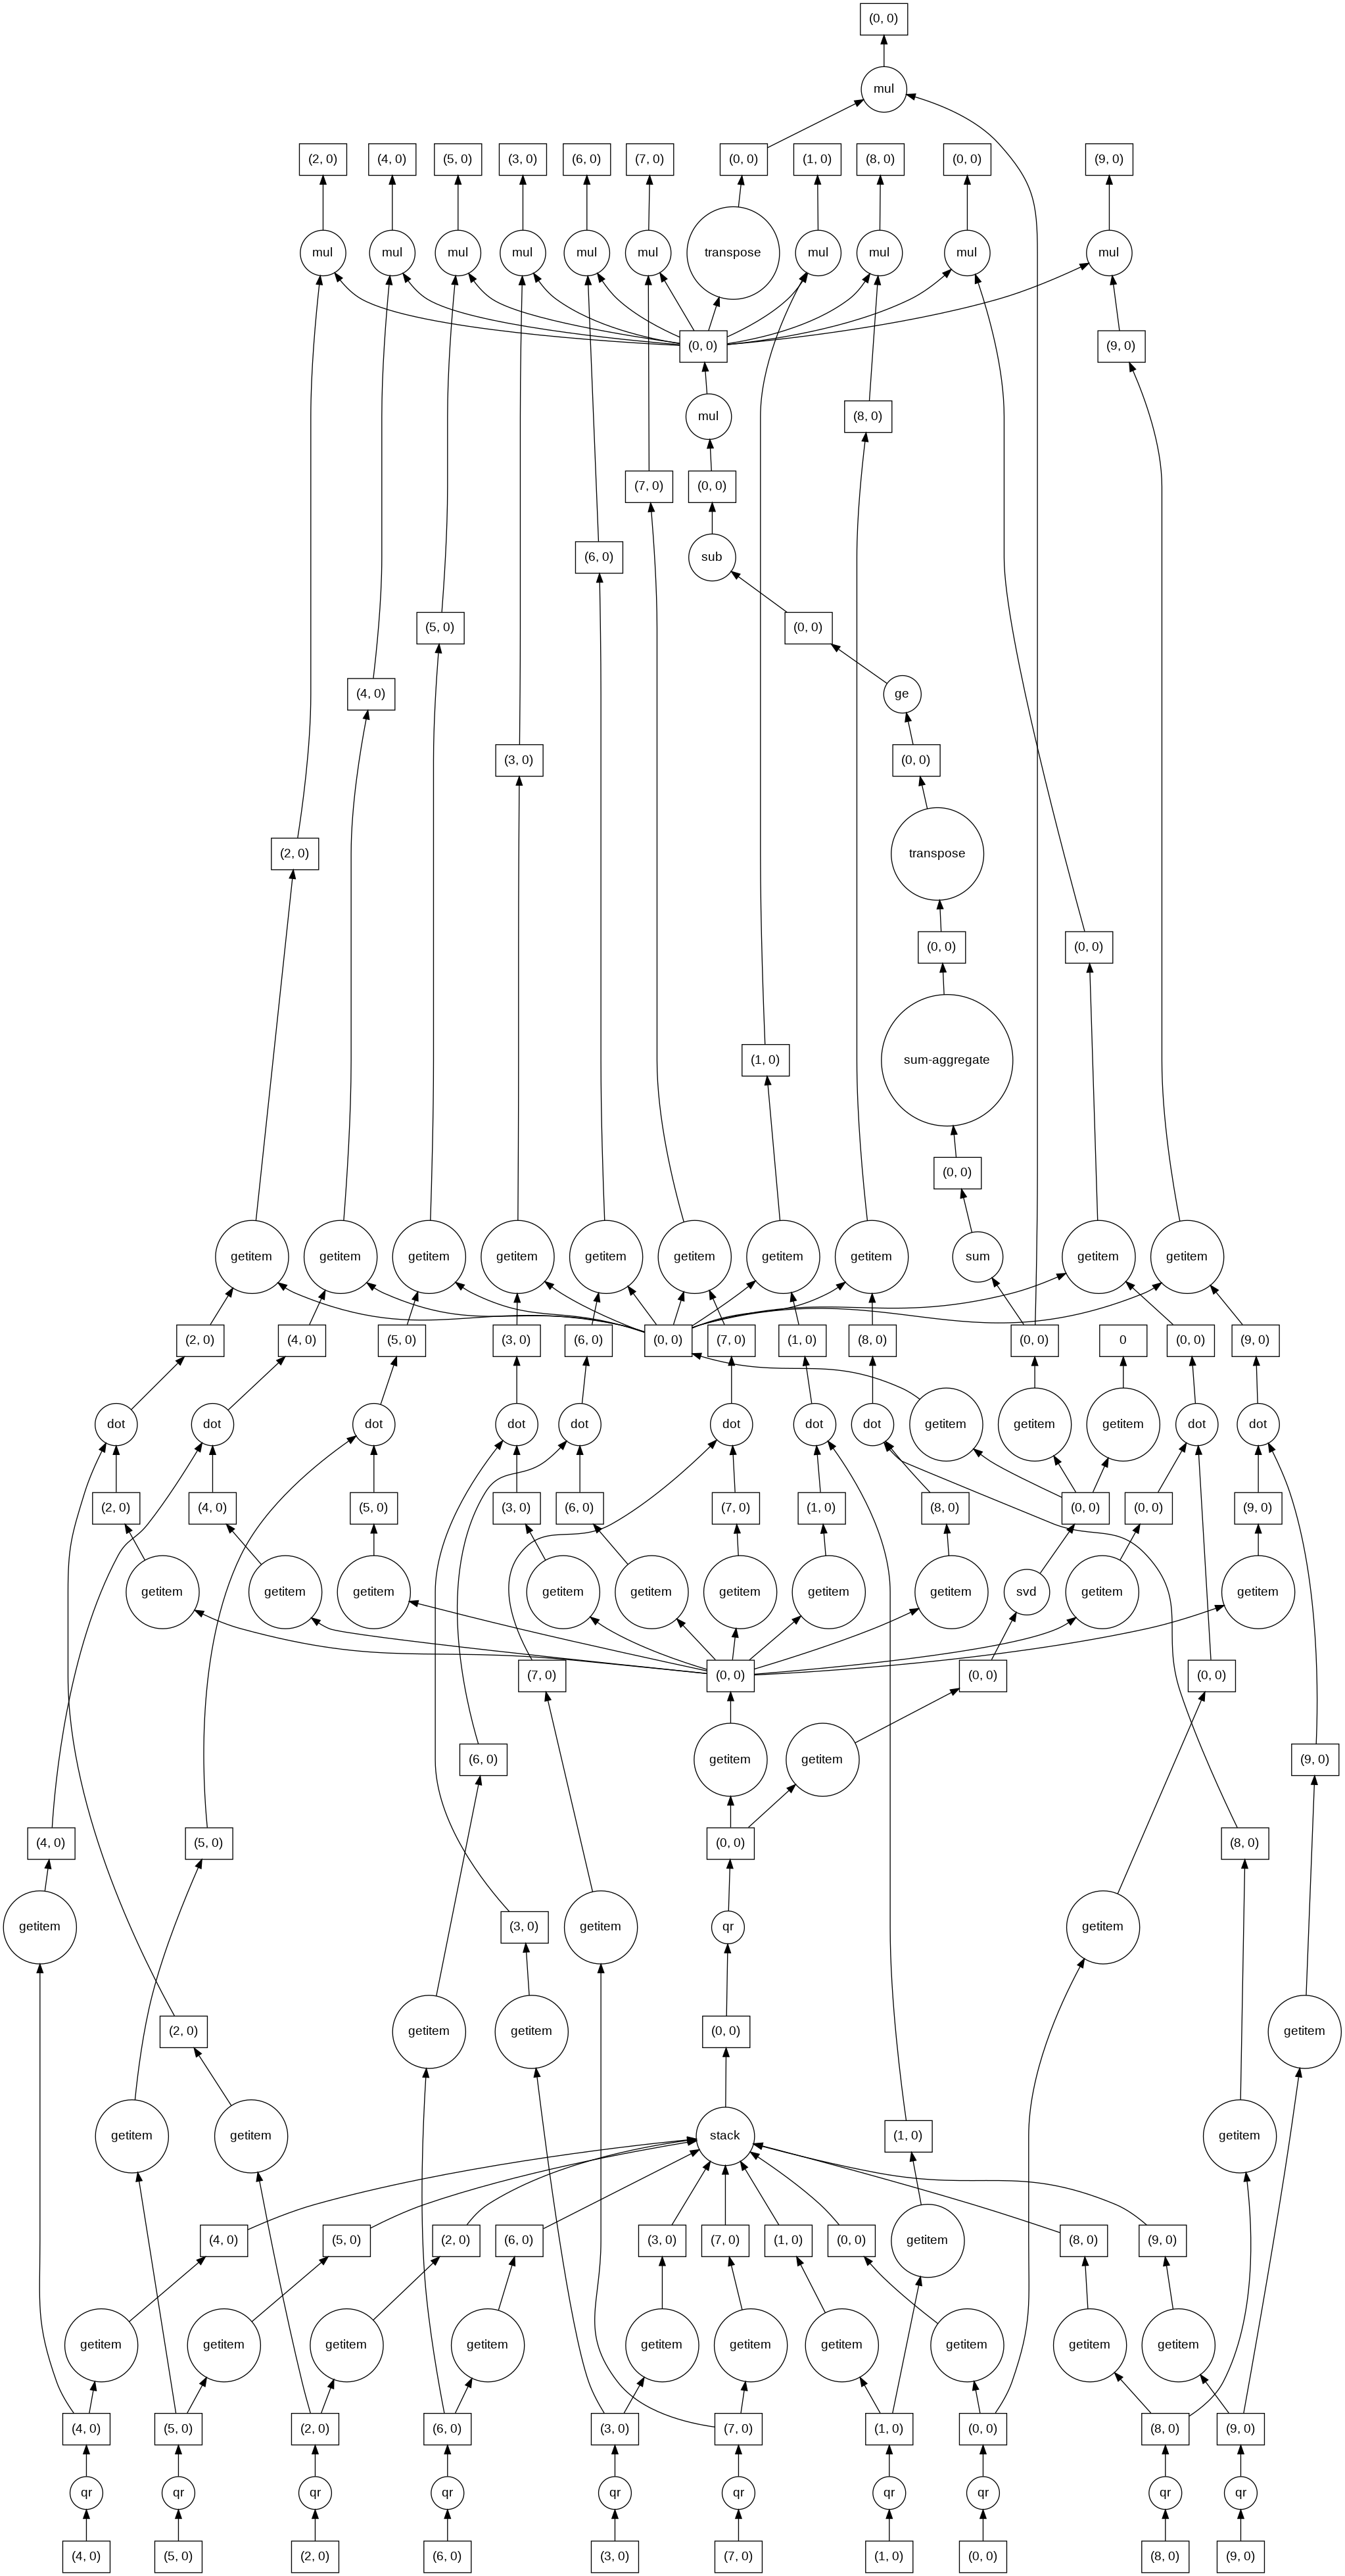

In [ ]:
### we can visualize the decomposition process.
u, s, v  = usv_decom_dd(x)
dask.visualize(u,s,v)

In [ ]:
u, s, v = dask.persist(u, s, v)

# RAPIDS demo

In [ ]:
%%capture
# This get the RAPIDS-Colab install files and test check your GPU.  Run this and the next cell only.
# Please read the output of this cell.  If your Colab Instance is not RAPIDS compatible, it will warn you and give you remediation steps.
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/env-check.py

In [ ]:
# This will update the Colab environment and restart the kernel.  Don't run the next cell until you see the session crash.
!bash rapidsai-csp-utils/colab/update_gcc.sh
import os
os._exit(00)

Updating your Colab environment.  This will restart your kernel.  Don't Panic!
Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [83.3 kB]
Get:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:9 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:11 http://security.ubuntu.com/ubuntu bionic-security/restricted amd64 Packages [1,187 kB]
Get:12 http://archive.ubuntu.com/ubuntu bionic-updates/restricted amd64 Pac

In [ ]:
# This will install CondaColab.  This will restart your kernel one last time.  Run this cell by itself and only run the next cell once you see the session crash.
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:25
🔁 Restarting kernel...


In [ ]:
# you can now run the rest of the cells as normal
import condacolab
condacolab.check()

✨🍰✨ Everything looks OK!


In [ ]:
# Installing RAPIDS is now 'python rapidsai-csp-utils/colab/install_rapids.py <release> <packages>'
# The <release> options are 'stable' and 'nightly'.  Leaving it blank or adding any other words will default to stable.
!python rapidsai-csp-utils/colab/install_rapids.py stable
import os
os.environ['NUMBAPRO_NVVM'] = '/usr/local/cuda/nvvm/lib64/libnvvm.so'
os.environ['NUMBAPRO_LIBDEVICE'] = '/usr/local/cuda/nvvm/libdevice/'
os.environ['CONDA_PREFIX'] = '/usr/local'

In [ ]:
from cuml import KMeans
import cudf
import pandas as pd
from google.colab import files
from google.colab import drive
import os
drive.mount('/content/gdrive', force_remount = True)

Mounted at /content/gdrive


In [ ]:
X_vec = cudf.read_csv(r'/content/gdrive/My Drive/Colab Notebooks/poi_data/x_vec.csv')
X_vec.drop("Unnamed: 0", axis = 1, inplace = True)
X_vec = X_vec.to_numpy()

In [ ]:
X_vec.shape

(2651577, 128)

In [ ]:
from sklearn.cluster import KMeans
def kmeans(X_vec = X_vec, num_clusters = 20):
  kmeans = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=5000, n_init=1, random_state=42)
  kmeans.fit(X_vec)

%time kmeans()

CPU times: user 3min 24s, sys: 6.78 s, total: 3min 31s
Wall time: 1min 59s


In [ ]:
from cuml import KMeans
def kmeans(X_vec = X_vec, num_clusters = 20):
  kmeans = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=5000, n_init=1, random_state=42)
  kmeans.fit(X_vec)

%timeit kmeans()

10.7 s ± 217 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


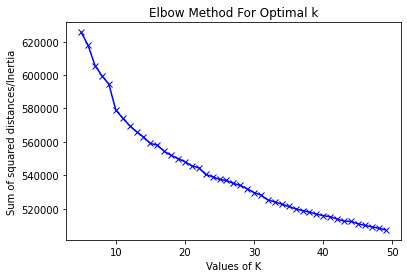

In [ ]:
import matplotlib.pyplot as plt
Sum_of_squared_distances = []
K = range(5,50)
for num_clusters in K :
  kmeans = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=5000, n_init=1, random_state=42)
  kmeans.fit(X_vec)
  Sum_of_squared_distances.append(kmeans.inertia_)
  
plt.plot(K,Sum_of_squared_distances,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method For Optimal k')
plt.show()